In [ ]:
!cp -r drive/Shareddrives/Virtuon/Machine\ Learning\ Project/Pre_Trained_Model/* /content

In [ ]:
!pip install tf-bodypix[all]

     |████████████████████████████████| 2.2MB 6.2MB/s 
     |████████████████████████████████| 49.5MB 88kB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 112kB 33.8MB/s 
  Created wheel for pyfakewebcam: filename=pyfakewebcam-0.1.0-cp36-none-any.whl size=12671 sha256=bf2cd7626f4d5a59649809cda770fb0ddf30fbba3aa160e816f47de83225692e
  Stored in directory: /root/.cache/pip/wheels/f9/f5/02/bce72cbe64394c0eac46cabc66a04e45370b78cb4d1704e5a0
Successfully built pyfakewebcam
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:

In [ ]:
!unzip /content/drive/Shareddrives/Virtuon/Machine\ Learning\ Project/LIP_Dataset/LIP_Dataset.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/103932_461359.png  
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/104021_1221482.png  
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/104453_480966.png  
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/104689_511815.png  
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/105545_2155923.png  
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/10710_428800.png  
  inflating: /content/LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/10764_471070.png  
  inflating: /content/LIP_Dataset/Train

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt
%matplotlib inline

from tf_bodypix.api import download_model, load_model, BodyPixModelPaths

In [ ]:
from model import build_model

In [ ]:
train_path = 'LIP_Dataset/TrainVal_images/TrainVal_images/train_images/'
val_path = 'LIP_Dataset/TrainVal_images/TrainVal_images/val_images/'

train_labels_path = 'LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/train_segmentations/'
val_labels_path = 'LIP_Dataset/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations/'


In [ ]:
train_data = pd.read_csv('LIP_Dataset/TrainVal_images/train_id.txt', header = None)
val_data = pd.read_csv('LIP_Dataset/TrainVal_images/val_id.txt', header = None)

In [ ]:
train_paths = pd.read_csv('LIP_Dataset/TrainVal_images/train_id.txt', header = None)
train_paths = train_paths.applymap(lambda x: "".join([ train_path, x, '.jpg' ]))

val_paths = pd.read_csv('LIP_Dataset/TrainVal_images/val_id.txt', header = None)
val_paths = val_paths.applymap(lambda x: "".join([val_path, x, '.jpg']))

train_label_paths = train_data.copy()
train_label_paths = train_label_paths.applymap(lambda x: "".join([train_labels_path, x, '.png']))

val_label_paths = val_data.copy()
val_label_paths = val_label_paths.applymap(lambda x: "".join([val_labels_path, x, '.png']))

In [ ]:
train_data = pd.read_csv('LIP_Dataset/TrainVal_images/train_id.txt', header = None)[0]
val_data = pd.read_csv('LIP_Dataset/TrainVal_images/val_id.txt', header = None)[0]

In [ ]:
train_paths = train_paths[0].to_numpy()
train_label_paths = train_label_paths[0].to_numpy()

val_paths = val_paths[0].to_numpy()
val_label_paths = val_label_paths[0].to_numpy()

In [ ]:
def preprocessing(image, label):
    image_string = tf.io.read_file(image)
 
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.io.decode_jpeg(image_string, channels=3)
 
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    resized_image = tf.image.resize(image, [im_height, im_height])
    
    #resized_image = tf.image.convert_image_dtype(resized_image, tf.uint8)
    
    image_string = tf.io.read_file(label)
 
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.io.decode_png(image_string, channels = 1)
    
    image = tf.reduce_sum(image, axis = -1)
    
    image = tf.one_hot(image, depth = n_class)
    
    resized_label_image = tf.image.resize(image, [im_height, im_height])
    
    return resized_image, resized_label_image

In [ ]:
bs = load_model(download_model(
    BodyPixModelPaths.MOBILENET_FLOAT_100_STRIDE_16
))

   8192/Unknown - 0s 0us/stepDownloading data from https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/100/group1-shard1of4.bin
   8192/Unknown - 0s 0us/stepDownloading data from https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/100/group1-shard2of4.bin
   8192/Unknown - 0s 0us/stepDownloading data from https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/100/group1-shard3of4.bin
   8192/Unknown - 0s 0us/stepDownloading data from https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/100/group1-shard4of4.bin
   8192/Unknown - 0s 0us/step

In [ ]:
cs = build_model()

In [ ]:
cs.load_weights("model.11-0.8409.hdf5")

In [ ]:
im_height, im_width, im_channels = (320,320,3)
n_classes = 20
common_interpolation = 'bilinear'

In [ ]:
def random_choice(image_size):
    height, width = image_size
    crop_height, crop_width = 320, 320
    x = random.randint(0, max(0, width - crop_width))
    y = random.randint(0, max(0, height - crop_height))
    return x, y
    
def safe_crop(mat, x, y):
    crop_height, crop_width = im_height, im_width
    if len(mat.shape) == 2:
        ret = np.zeros((crop_height, crop_width), np.float32)
    else:
        ret = np.zeros((crop_height, crop_width, 3), np.float32)
    crop = mat[y:y + crop_height, x:x + crop_width]
    h, w = crop.shape[:2]
    ret[0:h, 0:w] = crop
    return ret

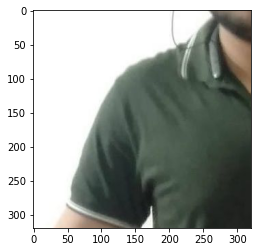

In [ ]:
test_path = "/content/132608198_534806407493745_1425275091272535235_n.jpg"
test = img_to_array(load_img(test_path))
x,y = random_choice(test.shape[:2])
plt.imshow(safe_crop(test, x, y)/255)

In [ ]:
def image(path):
    return img_to_array(load_img(path, target_size=(im_height, im_width), interpolation = common_interpolation))

def bodypix_output(path = None, img = False):
    if path != None:
        img = image(path)
    result = bs.predict_single(img)
    mask = result.get_mask(threshold = 0.75)
    c_mask = result.get_colored_part_mask(mask)
    # c_mask = tf.math.argmax(c_mask, axis = -1)
    return c_mask

def segnet_output(path):
    output = cs.predict(image(path).reshape( (1, im_height, im_width, im_channels) )/255.0)
    output = output.reshape((im_height, im_width, n_classes))
    return output


In [ ]:
(batch_size, im_height, im_width, im_channels)

In [ ]:
test_path = train_paths[6]
test = img_to_array(load_img(test_path))

In [ ]:
test = image(train_paths[0])

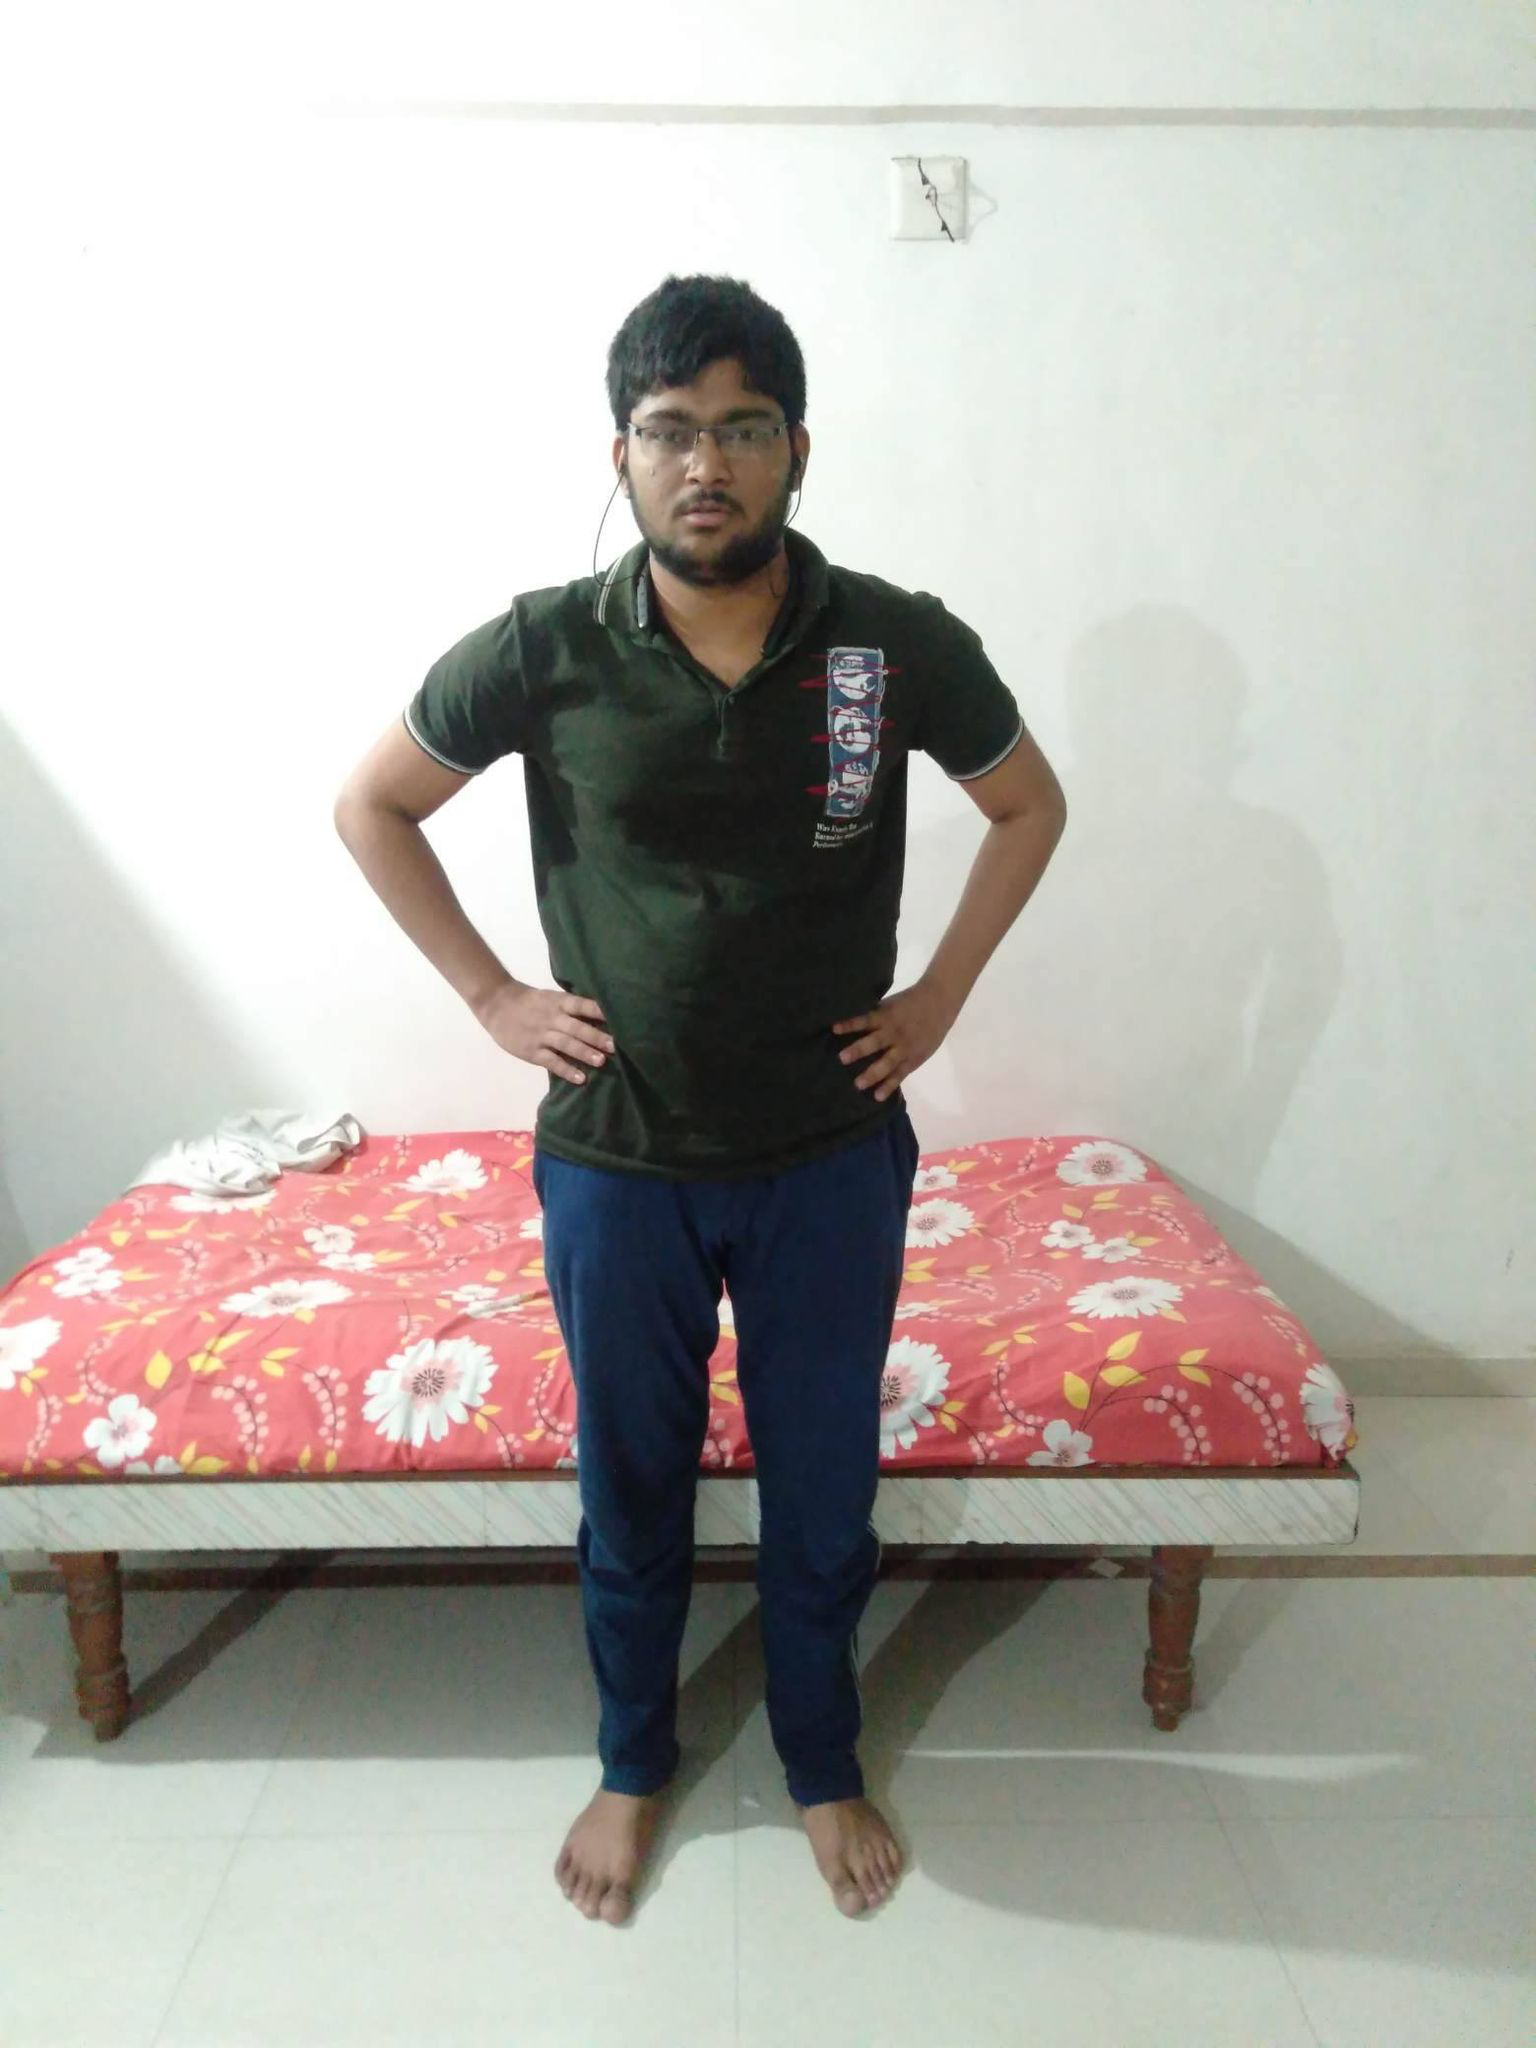

In [ ]:
load_img("/content/132641661_257761672354293_6255432033920122346_n.jpg")

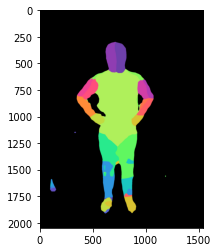

In [ ]:
plt.imshow(bodypix_output(
    img = img_to_array(
    load_img("/content/132641661_257761672354293_6255432033920122346_n.jpg")
    )
    ))

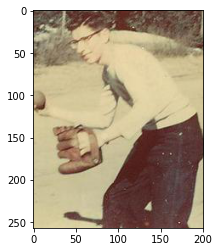

In [ ]:
plt.imshow(test/255)

In [ ]:
test.shape

(257, 201, 3)

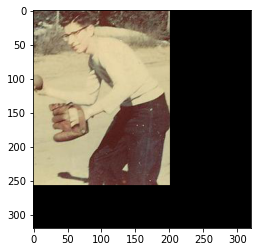

In [ ]:
test_path

'LIP_Dataset/TrainVal_images/TrainVal_images/train_images/1000_1234574.jpg'

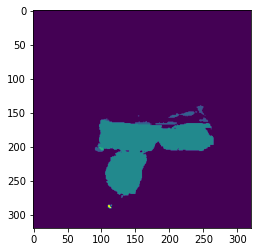

In [ ]:
plt.imshow(tf.math.argmax(segnet_output(test_path), axis = -1))